In this lab, you are supposed to do the following tasks related to parameter estimation in state-space models.

1. Simulation of a parametrised non-linear SSM.
2. Using a filter (e.g., EKF, CKF, or PF, up to your choice) to approximately compute the negative loglikelihood with respect to the parameter. Plot a landscape of the negative loglikelihood as a function of the parameter.
3. Use numerical optimisation to find the maximum likelihood estimate of the parameter.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Setup
Let's first import necessary libraries and set a random seed.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Tuple

np.random.seed(666)

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 20})

# Task 1: Simulating a pendulum model

The pendulum model is detailed in LE 7, where we used a state $X_k = \begin{bmatrix} X_{k, 1}, X_{k, 2} \end{bmatrix}$ to encode the angle and the angular velocity at time $t_k$, respectively.
This model can be approximately represented in an SSM given by

$$
\begin{equation}
    \begin{split}
        \begin{bmatrix}
            X_{k, 1} \\ X_{k, 2}
        \end{bmatrix}
        &=
        \overbrace{%
            \begin{bmatrix}
                X_{k-1, 1} + X_{k-1, 2} \, \Delta \\
                X_{k-1, 2} - g \sin(X_{k-1, 1}) \, \Delta
            \end{bmatrix} }^{f(\cdot)}
        + q_k, \\
        Y_k &= \underbrace{\sin(X_{k, 1})}_{h(\cdot)} + \xi_k,
    \end{split}
\end{equation}
$$
where $q_k \sim \mathrm{N}(0, \Sigma_{k-1})$ with $\Sigma_{k-1} = \mathrm{diag}(0, 0.1^2 \, \Delta)$, and $\Delta$ is the time interval.
We assume that we can measure the horizontal position of the ball.

You are asked to simulate a path $X_{0:N}$ from the model at the time steps $t_0 < t_1 < \cdots < t_N = T$, and the corresponding observations $Y_{0:N}$.

Importantly, note the gravity constant $g$! When you implement the model, make sure that your implementation takes the parameter $g$ as an input.

In [16]:
# As usual, we start by defining the time grid.

t0 = 0.
nsteps = 1000
T = 5.
ts = np.linspace(t0, T, nsteps + 1)
dt = T / nsteps

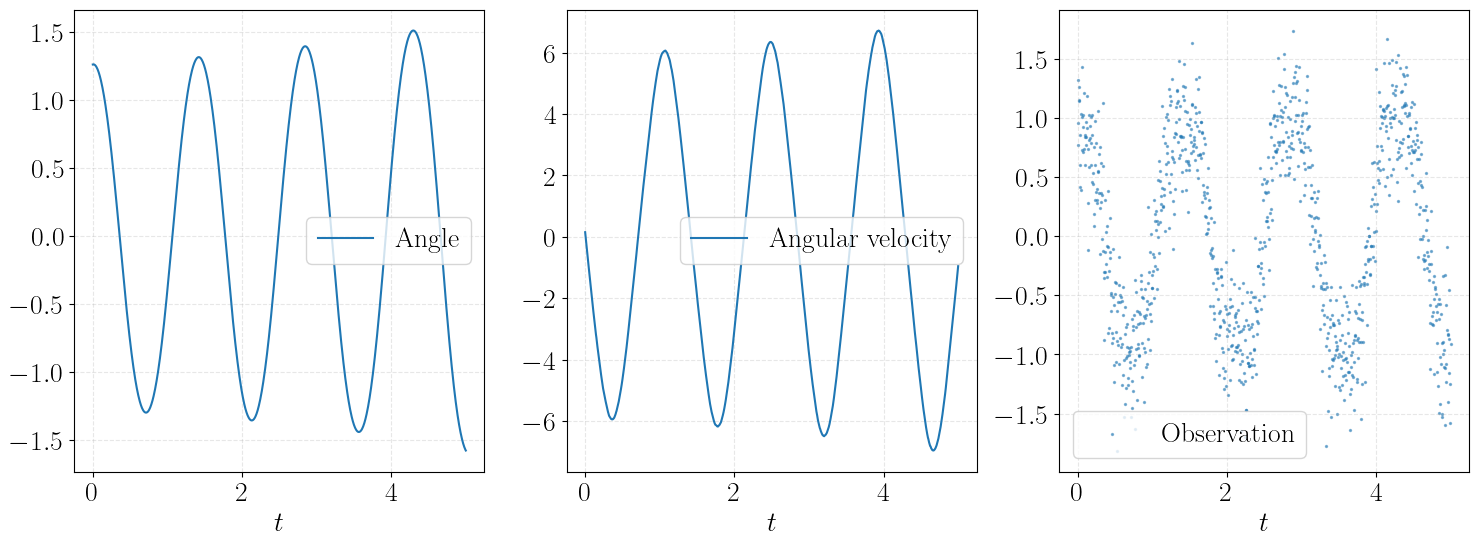

In [17]:
d = 2  # The dimension of the state
true_g = 24.79  # Earth is boring, let's assume that we are on Jupiter

Sigma = np.array([[0., 0.],
                  [0., 0.1 ** 2 * dt]])
xi = 0.1


def f(x: np.ndarray,
      g: float) -> np.ndarray:
    """The state transition function of the pendulum model.

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at the previous time step.
    g : float
        The gravity constant.

    Returns
    -------
    np.ndarray (...)
    """
    return np.array([x[...,0]+x[...,1]*dt
                    ,x[...,1]-g*np.sin(x[...,0])*dt])


def h(x: np.ndarray) -> np.ndarray:
    """The observation function of the pendulum model.

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at the current time step.

    Returns
    -------
    np.ndarray (...)
    """
    return np.array([np.sin(x[...,0])])


# Pre-allocate a container to store the states (note that this includes X0)
xs = np.zeros((nsteps + 1, d))
ys = np.zeros((nsteps + 1,))

# The initial state
m0, v0 = np.array([1., 0.]), 0.1 * np.eye(d)

# Generate the initial state and observation
x0 = m0 + np.linalg.cholesky(v0) @ np.random.randn(d)
# extract the value from array by y0 = h(x0)[0]
y0 = h(x0)[0] + xi ** 0.5 * np.random.randn()
xs[0] = x0
ys[0] = y0

# Simulate a path from the LGSSM
for k in range(1, nsteps + 1):
    # process noise only on angular velocity, std = 0.1 * sqrt(dt)
    noise = np.array([0.0, 0.1 * np.sqrt(dt) * np.random.randn()])
    xs[k] = f(xs[k-1],true_g) + noise
    # extract the value from array by h(xs[k])[0]
    ys[k] = h(xs[k])[0]+ xi ** 0.5 * np.random.randn()

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
_ = axes[0].plot(ts, xs[:, 0], label='Angle')
_ = axes[1].plot(ts, xs[:, 1], label='Angular velocity')
_ = axes[2].scatter(ts, ys, s=2, alpha=.5, label='Observation')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.set_xlabel('$t$')
    ax.legend()

# Task 2: Filtering and negative loglikelihood computation

Choose any filter you like (e.g., EKF, CKF, or PF) to do the filtering of the model. In addition to the filtering results, your implementation should take the parameter $g$ as an input and out the negative loglikelihood $-\log p(y_{1:N}; g)$ given the parameter $g$.

Take CKF for example, you implemented function should have signature

```python
def ckf(m0, v0, g):
    ...
    return mfs, vfs, nell
```

where `nell` stands for the negative loglikelihood. Or in particle filter, you might have

```python
def bootstrap_pf(log_ws0, samples0, g):
    ...
    return log_wss, sampless, nell
```

In [18]:
from scipy.stats import multivariate_normal
def jacobian_f(x: np.ndarray,
      g: float) -> np.ndarray:
    """The Jacobian of the state transition function.

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at the previous time step.
    g : float
        The gravity constant.

    Returns
    -------
    np.ndarray (d,d)
    """
    return np.array([[1, dt],
                    [-g*np.cos(x[...,0])*dt, 1]])

def jacobian_h(x: np.ndarray) -> np.ndarray:
    """The Jacobian of the observation function.

    Parameters
    ----------
    x : np.ndarray (..., d)
        The state at the current time step.

    Returns
    -------
    np.ndarray (1,d)
    """
    return np.array([[np.cos(x[...,0]), 0.]])

def ekf_pred(mf: np.ndarray,
             vf: np.ndarray,
             g: float) -> Tuple[np.ndarray, np.ndarray]:
 
    mp = f(mf,g)
    vp = jacobian_f(mf,g) @ vf @ jacobian_f(mf,g).T + Sigma
    return mp, vp
    

def ekf_update(mp: np.ndarray,
             vp: np.ndarray,
             yk: np.ndarray,
             ) -> Tuple[np.ndarray, np.ndarray, float]:
    
    H = jacobian_h(mp)
    sk = H @ vp @ H.T + xi 
    ck = vp @ H.T

    # Cholesky factorization 
    cho_fac, lower = scipy.linalg.cho_factor(sk)
    sk_inv = scipy.linalg.cho_solve((cho_fac, lower), np.eye(1))
    # innovation must be computed with the nonlinear function rather than H@ m
    mf = mp + ck @ sk_inv @ (yk- h(mp)) 
    vf = vp-ck @sk_inv @ ck.T
    log_lik = multivariate_normal.logpdf(yk, mean=h(mp), cov=sk)
    return mf, vf, log_lik


In [19]:
# In this code cell, implement you filter that returns the negative loglikelihood
def ekf (m0, v0, g):
    mfs = np.zeros((nsteps + 1, d))  # Filtering means
    vfs = np.zeros((nsteps + 1, d, d))  # Filtering covariances
    nell = np.zeros(nsteps+1)
    
    mf0, vf0, log_lik0 = ekf_update(m0, v0, y0)
    mfs[0] = mf0
    vfs[0] = vf0
    nell[0] = log_lik0
    
    for k in range (1, nsteps+1) :
        mp, vp = ekf_pred(mfs[k-1], vfs[k-1], g)
        mfs[k], vfs[k], nell[k]= ekf_update(mp,vp,ys[k])
        
    return mfs, vfs, nell

Before we move on to the next, let's first do a sanity check.
We run the filter with the true parameter `true_g` to see if it works correctly.
Visualise the filtering results.

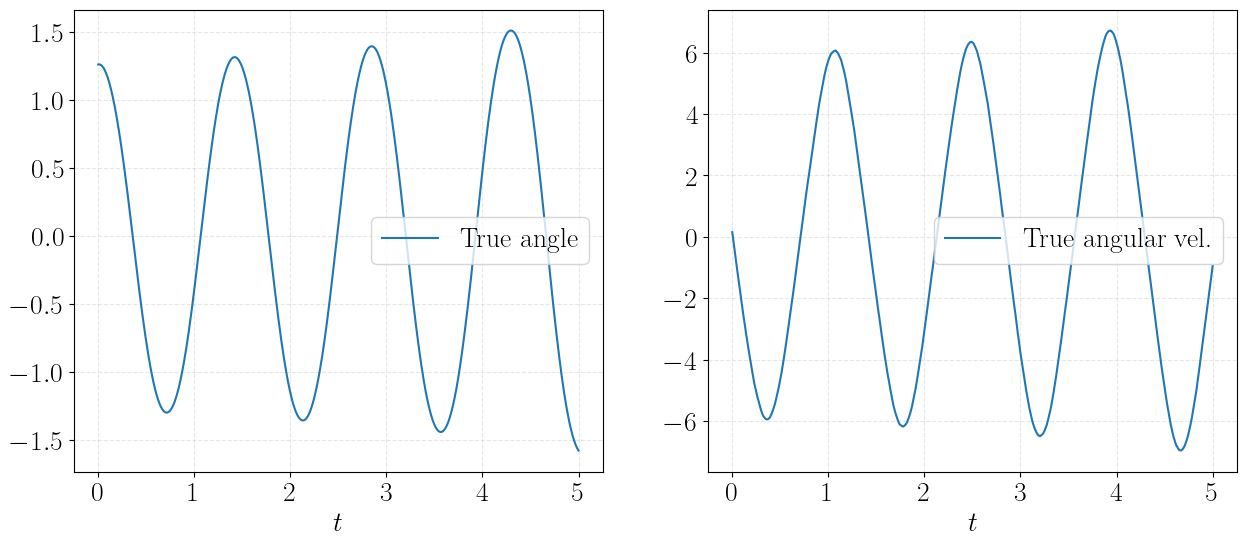

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
_ = axes[0].plot(ts, xs[:, 0], label='True angle')
_ = axes[1].plot(ts, xs[:, 1], label='True angular vel.')

# Visualise the filtering results in the respective subplots
ekf(m0,v0,true_g)

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')
    ax.set_xlabel('$t$')
    ax.legend()

# Task 3: MLE

Suppose that the parameter $g$ is unknown, and we wish to estimate it by optimising with respect to a loss function defined in terms of maximum likelihood estimation:

$$
\mathrm{loss}(g) = -\log p(y_{0:N}; g).
$$

Your first task is to implement this loss function using the negative loglikelihood computed by the filter.

After you have defined such a loss function, we will visualise a landscape of the function with 100 candidate values of $g$ around the true value.

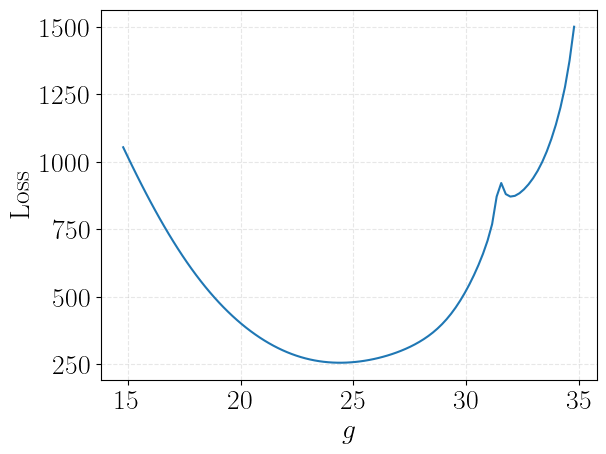

In [21]:
def loss_fn(g):
    g = np.atleast_1d(g)[0]
    return -np.sum(ekf(m0,v0,g)[2])


gs = np.linspace(true_g - 10, true_g + 10, 100)  # try 100 candidate values of g
losses = np.zeros(100)  # a container to store the losses

# This might take a while
for i, g in enumerate(gs):
    losses[i] = loss_fn(g)

fig, ax = plt.subplots()
ax.plot(gs, losses)
ax.set_xlabel('$g$')
ax.set_ylabel('Loss')
ax.grid(linestyle='--', alpha=0.3, which='both')

The loss function should look fairly smooth.

Now, use an optimiser to find the maximum likelihood estimate of the parameter $g$ by minimising the loss function.
You are free to choose any optimiser you like, e.g., gradient descent, L-BFGS-B, or even just grid search.

You are supposed to see that the learnt value of $g$ is close to the true value, but not exactly equal to it.

In [22]:
from scipy.optimize import minimize

In [23]:
# Implement the optimisation here and print the results
# use the BFGS method
estimated_g = minimize(loss_fn, [10.], method='BFGS').x[0]

print(f'True g: {true_g} vs estimated g: {estimated_g}')

True g: 24.79 vs estimated g: 24.40543959685847


# Question 1

Empirically, the estimated $g$ is not equal to the true $g$. Identify and explain **at least three** sources of errors that can lead to this discrepancy. Suggest ways to mitigate these errors.

The EKF uses first‑order Taylor expansions of the nonlinear transition and observation around the current mean. 

Solution: Use a higher‑order Gaussian filter (UKF / CKF), an iterated EKF, or a particle filter (more accurate likelihood).

Without an analytic gradient, BFGS uses finite differences on a noisy (approximate EKF) loss, and stops at a tolerance, yielding only an approximate minimiser.  

Solution: Provide analytic/AD gradient, tighten tolerances, do coarse grid then local refine.

MLE is only asymptotically consistent, a single noisy trajectory with N = 1000 still has enough sampling variability that the estimated g need not match the true value exactly.

Solution: Use more time steps, do multiple independent simulations, or report confidence intervals.



# Question 2

You have chosen either using a Gaussian filter or particle filter to compute the loss function.
Explain in both cases, whether the loss function is *differentiable* with respect to the parameter $g$.
Given this, would a particle filter works better or worse than a Gaussian filter when doing a gradient-based optimisation?

In the case of Gaussion filter, the function is smooth as plotted, and it is considered to be differentiable with respect to parameter g, given enough N.
While partcile filter gives a Monte‑Carlo estimate of the likelihood from discrete resampling and particle noise makes finite‑difference gradients very high variance. 

When doing a gradient-based optimisation, Gaussion filter gives a smoother and lower-variance gradients, thus is more suitable than particle filter.

# Contribution statement

If you have teamed up with someone, please write down the contribution of each team member in this cell. If you worked alone, you can leave this cell empty.

This assignment was completed as a team effort with equal contributions from Xiaochen and Nisal. Xiaochen is responsible for task 1 and 2, Nisal is responsible for task 3 and the question part.
